--- 
Project for the course in Microeconometrics | Summer 2019, Bonn University | Annica Gehlen

# Replication of Jason M. Lindo, Nicholas J.  Sanders & Philip Oreopoulos  (2010) <a class="tocSkip">   
---

This notebook contains my replication of the results from the following paper:

> Lindo, J. M., Sanders, N. J., & Oreopoulos, P. (2010). Ability, gender, and performance standards: Evidence from academic probation. American Economic Journal: Applied Economics, 2(2), 95-117.

#### Downloading and viewing this notebook:

* The best way to view this notebook is by downloading it and the repository it is located from [GitHub](https://github.com/HumanCapitalAnalysis/student-project-amageh). Other viewing options like _mybinder_ or _nbviewer_ may have issues with displaying images or coloring of certain parts (missing images can be viewed in the folder [files](https://github.com/HumanCapitalAnalysis/student-project-amageh/tree/master/files) on GitHub).


* The original paper as well the data and code provided by the authors can be accessed [here](https://www.aeaweb.org/articles?id=10.1257/app.2.2.95).

#### Information about replication and individual contributions:

* For the replication part I try to remain true to the original structure of the paper so readers can easily follow along and compare. All tables and figures are named and labeled as they appear in Lindo et al. (2010).


* The tables in my replication appear transposed compared to the original tables to suit my workflow in Python.


* For transparency, all sections in the replication that constitute independent contributions by me and are not part of results presented (or include deviations from the methods used) in the paper are marked as _extensions_. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Introduction" data-toc-modified-id="1.-Introduction-1">1. Introduction</a></span></li><li><span><a href="#2.-Theoretical-Background" data-toc-modified-id="2.-Theoretical-Background-2">2. Theoretical Background</a></span></li><li><span><a href="#3.-Identification" data-toc-modified-id="3.-Identification-3">3. Identification</a></span></li><li><span><a href="#4.-Empirical-Strategy" data-toc-modified-id="4.-Empirical-Strategy-4">4. Empirical Strategy</a></span></li><li><span><a href="#5.-Replication-of-Lindo-et-al.-(2010)" data-toc-modified-id="5.-Replication-of-Lindo-et-al.-(2010)-5">5. Replication of Lindo et al. (2010)</a></span><ul class="toc-item"><li><span><a href="#5.1.-Data-&amp;-Descriptive-Statistics" data-toc-modified-id="5.1.-Data-&amp;-Descriptive-Statistics-5.1">5.1. Data &amp; Descriptive Statistics</a></span></li><li><span><a href="#5.2.-Results" data-toc-modified-id="5.2.-Results-5.2">5.2. Results</a></span><ul class="toc-item"><li><span><a href="#5.2.1.-Tests-of-the-Validity-of-the-RD-Approach" data-toc-modified-id="5.2.1.-Tests-of-the-Validity-of-the-RD-Approach-5.2.1">5.2.1. Tests of the Validity of the RD Approach</a></span></li><li><span><a href="#i.--Extension:-Visual-Validity-Check" data-toc-modified-id="i.--Extension:-Visual-Validity-Check-5.2.2">i.  Extension: Visual Validity Check</a></span></li><li><span><a href="#ii.-Advanced-Validity-Check" data-toc-modified-id="ii.-Advanced-Validity-Check-5.2.3">ii. Advanced Validity Check</a></span></li><li><span><a href="#5.2.2.-First-year-GPAs-and-Academic-Probation" data-toc-modified-id="5.2.2.-First-year-GPAs-and-Academic-Probation-5.2.4">5.2.2. First year GPAs and Academic Probation</a></span></li><li><span><a href="#5.2.3.-The-Immediate-Response-to-Academic-Probation" data-toc-modified-id="5.2.3.-The-Immediate-Response-to-Academic-Probation-5.2.5">5.2.3. The Immediate Response to Academic Probation</a></span></li><li><span><a href="#5.2.4.-The-Impact-on-Subsequent-Performance" data-toc-modified-id="5.2.4.-The-Impact-on-Subsequent-Performance-5.2.6">5.2.4. The Impact on Subsequent Performance</a></span></li><li><span><a href="#i.-Main-Results-for-Impact-GPA-&amp;-Probability-of-placing-above-Cutoff-in-the-next-Term" data-toc-modified-id="i.-Main-Results-for-Impact-GPA-&amp;-Probability-of-placing-above-Cutoff-in-the-next-Term-5.2.7">i. Main Results for Impact GPA &amp; Probability of placing above Cutoff in the next Term</a></span></li><li><span><a href="#ii.-Formal-Bound-Analysis-on-Subsequent-GPA-(partial-extension)" data-toc-modified-id="ii.-Formal-Bound-Analysis-on-Subsequent-GPA-(partial-extension)-5.2.8">ii. Formal Bound Analysis on Subsequent GPA (partial extension)</a></span></li><li><span><a href="#5.2.5.-The-Impacts-on-Graduation" data-toc-modified-id="5.2.5.-The-Impacts-on-Graduation-5.2.9">5.2.5. The Impacts on Graduation</a></span></li></ul></li></ul></li><li><span><a href="#6.-Extension:-Robustness-Checks" data-toc-modified-id="6.-Extension:-Robustness-Checks-6">6. Extension: Robustness Checks</a></span><ul class="toc-item"><li><span><a href="#6.1.--A-closer-look-at-student's-subsequent-performance." data-toc-modified-id="6.1.--A-closer-look-at-student's-subsequent-performance.-6.1">6.1.  A closer look at student's subsequent performance.</a></span><ul class="toc-item"><li><span><a href="#6.1.1.-Subsequent-Performance-and-Total-Credits-in-Year-2" data-toc-modified-id="6.1.1.-Subsequent-Performance-and-Total-Credits-in-Year-2-6.1.1">6.1.1. Subsequent Performance and Total Credits in Year 2</a></span></li><li><span><a href="#6.1.2.-Subsequent-Cumulative-Grade-Point-Average-(CGPA)" data-toc-modified-id="6.1.2.-Subsequent-Cumulative-Grade-Point-Average-(CGPA)-6.1.2">6.1.2. Subsequent Cumulative Grade Point Average (CGPA)</a></span></li></ul></li><li><span><a href="#6.2.-Bandwidth-sensitivity" data-toc-modified-id="6.2.-Bandwidth-sensitivity-6.2">6.2. Bandwidth sensitivity</a></span></li></ul></li><li><span><a href="#7.-Conclusion" data-toc-modified-id="7.-Conclusion-7">7. Conclusion</a></span></li><li><span><a href="#8.-References" data-toc-modified-id="8.-References-8">8. References</a></span></li></ul></div>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.formats.style
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm_api
import matplotlib as plt
from IPython.display import HTML

In [2]:
from auxiliary.auxiliary_predictions import *
from auxiliary.auxiliary_plots import *
from auxiliary.auxiliary_tables import *
from auxiliary.auxiliary_misc import *

---
# 1. Introduction 
---

Lindo et al. (2010) examine the effects of academic probation on student outcomes using data from Canada. Academic probation is a university policy that aims to improve the performance of the lowest scoring students. If a student's Grade Point Average (GPA) drops below a certain threshold, the student is placed on academic probation. The probation status serves as a warning and does not entail immediate consequences, however, if students fail to improve their grades during the following term, they face the threat of being suspended from university. In a more general sense, academic probation may offer insights into how agents respond to negative incentives and the threat of punishment in a real world context with high stakes. 

To estimate the causal impact of being placed on probation, Lindo et al. (2010) apply a **regression discontinuity design (RDD)** to data retrieved from three campuses at a large Canadian university. The RDD is motivated by the idea that the students who score just above the threshold for being put on academic probation provide a good counterfactual to the 'treatment group' that scores just below the threshold. In line with the performance standard model that serves as the theoretical framework for the paper, Lindo et al. (2010) find that being placed on probation induces students to drop out but increases the grades of the students who remain in school. The authors also find large heterogeneities in the way different groups of students react to academic probation.

**Main variables** 

| **Treatment**     | **Main outcomes**       | **Main Covariates**    |
|-------------------|-------------------------|------------------------|
| Academic probation| Drop-out rates          | Gender                 |
| .                 | Subsequent performance  | HS grades              |                         
| .                 | Graduation rates        | Native language        |

 
In this Notebook I replicate the results presented in the paper by Lindo et al. (2010). Furthermore, I discuss in detail the identification strategy used by the authors and evaluate the results using multiple robustness checks. My analysis offers general support for the findings of Lindo et al. (2010) and points out some factors which may enable a deeper understanding of the causal relationship explored in the paper. 

This notebook is structured as follows. In the next section I present the performance standard model that lays down the theoretical framework for the paper (Section 2). In Section 3 I analyze the identification strategy that Lindo et al. (2010) use to unravel the causal effects of academic probation on student outcomes and Section 4 briefly discusses the empirical strategy the authors use for estimation. Section 5 and Section 6 constitute the core of this notebook. Section 5 shows my replication of the results in the paper and discussion thereof. In Section 6 I conduct various robustness checks and discuss some limitations of the paper. Section 7 offers some concluding remarks. 


---
# 2. Theoretical Background
---
The underlying framework used for the analysis is a model developed by Bénabou and Tirole (2000) which models agent's responses to a performance standard. While Bénabou and Tirole (2000) model a game between a principal and an agent, Lindo et al. (2010) focus only on an agent to relate the model to the example of academic probation. 

In the performance standard model, the agents face a choice between three options:
 1. **Option 1**: Incurs cost $c_1$ and grants benefit $V_1$ if successful.
 2. **Option 2**: Incurs cost $c_2$ and grants benefit $V_2$ if successful.
 3. **Neither** option: Incurs 0 cost and 0 benefit.
 
Option 1 has a lower cost and a lower benefit than option 2 such that:

\begin{equation}
    0 < c_1 < c_2 ,  0 < V_1 < V_2.
\end{equation}

Ability, denoted by $\theta$, translates to the probability of successfully completing either option. Assuming agents have perfect information about their ability, they solve the maximizing problem

\begin{equation}
max\{0, \theta V_1-c_1, \theta V_2-c_2\}.
\end{equation}
  
Let $\underline{\theta}$ be the ability level where the agent is indifferent between neither and option two and let $\bar{\theta}$ be the ability level at which the agent is indifferent between option 1 and option 2. Assuming that

\begin{equation}
\underline{\theta} \equiv \frac{c_1}{V_1} < \bar{\theta} \equiv \frac{c_2-c_1}{V_2-V1} < 1
\end{equation}

ensures that both options are optimal for at least some $\theta$.

It can be shown that 
* the lowest ability types ($\theta < \underline{\theta}$) choose neither option,
* the highest ability types ($\bar{\theta} < \theta$) choose the difficult option,
* the individuals in between the high and low type $\underline{\theta}< \theta < \bar{\theta} $) choose the easier option.

If the principal now removes option 1 or makes choosing this option much more costly, then the agent will choose option 2 if and only if

\begin{equation}
\theta \ge \frac{c_2}{V_2} \equiv \theta^*
\end{equation}


and choose neither option otherwise. The agents who would have chosen option 1 now split according to ability. Agents with high ability (specifically those with $\theta \in [\theta^*,\bar{\theta}]$) work harder thereby choosing option 2 while low ability types (those with $\theta \in [\underline{\theta}, \theta^*]$) do not pursue option 2 (and thus choose neither option).

In the context of academic probation, students face a similar decision and possible courses of action. Students whose GPA is just above the probation cutoff face the full set of options for the next year:

1. **Option 1**: Return to school and exhibit low effort and leading to a low GPA
2. **Option 2**: Return to school and exhibit high effort with the intent of achieving a high GPA
3. **Neither** option: Drop out of university

Students who score below the probation cutoff face a restricted set of options, as the university administration essentially eliminates option 1 by suspending students if they do not improve their grades. 

Lindo et al. (2010) formulate three testable implications of this theoretical framework: 

  * _Forbidding option 1 will **increase the overall probability of students dropping out**._
  * _Forbidding option 1 will **increase the performance of those who return**._
  * _Forbidding option 1 will cause **relatively low-ability students to drop out** and **relatively high-ability students to return and work harder**._

---
# 3. Identification
--- 
Lindo et al. (2010) in their paper aim to evaluate how academic probation affects students, specifically their probability of dropping out of university and whether it motivates those who remain to improve their grades. Students are placed on probation if their Grade Point Average (GPA) drops below a certain threshold and face the threat of suspension if they fail to improve their GPA in the next term. Students are thus clearly separated into a treated group (who is put on probation) and an untreated group based on their GPA. 

The causal graph below illustrates the relationship between the assignment variable $X$, treatment $D$ and outcome $Y$. While $X$ (the GPA) directly assigns students to treatment, it may also be linked to student outcomes. Additionally, there may be observables $W$ and unobservables $U$ also affecting $X$,$D$ and $Y$. There are thus multiple backdoor paths that need to be closed in order to isolate the effect academic probation. Simply controlling for the variables in question in this case does not suffice since there are unobservables that we cannot condition on. A randomized experiment on the other hand could eliminate selection bias in treatment by randomly assigning probation to students. The research question evaluated in the paper constitutes a classic policy evaluation problem in economics where we try to understand the causal implications of a policy without being able to observe the counterfactual world where the policy is not administered. However, like many problems in economics a randomized experiment in this context is not possible since putting students on probation has real world consequences that can affect students for the rest of their lives.

![ERROR:Here should be causal graph 1](files/causalgraph1.PNG)

Since it is not possible to randomize assignment to treatment, another method is needed to isolate the effects of academic probation on student outcomes. Lindo et al. (2010) apply a regression discontinuity design (RDD) to the problem at hand, a method pioneered by Thistlethwaite and Campbell (1960) in their analysis of the effects of scholarships on student outcomes. In fact, the identification problem in Lindo et al. (2010) is quite similar to that of Thistlethwaite and Campbell (1960) as both papers evaluate the causal effects of an academic policy on student outcomes. However, while the scholarship administered to high performing students in Thistlethwaite and Campbell (1960) constitutes a positive reinforcement for these students, Lindo et al. (2010) examine the effects of a negative reinforcement or penalty on low performing students. This means that, in contrast to Thistlethwaite and Campbell (1960) and many other applications of RD, our treatment groups lies _below_ the cutoff and not above it. This does not change the causal inference of this model but it might be confusing to readers familiar with RD designs and should thus be kept in mind. 

The regression discontinuity design relies on the assumption of local randomization, i.e. the idea that students who score just above the cutoff do not systematically differ from those who score below the cutoff and thus pose an appropriate control group for the students who are placed on probation. This identification strategy relies on the assumption that students are unable to precisely manipulate their grades to score just above or below the probation threshold. Within the neighborhood around the discontinuity threshold the RDD thus in a sense mimics a randomized experiment. 

To explain how the use of regression discontinuity allows Lindo et al. (2010) to identify treatment effects, I draw on material provided in Lee and Lemieux (2010) and their discussion on the RDD in the potential outcomes framework. As mentioned above, for each student $i$ we can image a potential outcome where they are placed on probation $Y_i(1)$ and where they are not $Y_i(0)$ but we can never simultaneously observe both outcomes for each student. Since it is impossible to observe treatment effects at the individual level, researchers thus estimate average effects using treatment and control groups. 

For the RDD this potential outcomes framework translates by imagining there are two underlying relationships between the average student outcome and the assignment variable $X$ (the students' GPA), which are represented by $E[Y_i(1)|X]$ and $E[Y_i(0)|X]$. Since all students who score below the cutoff $c$ are placed on probation, we only observe $E[Y_i(1)|X]$ for those below the cutoff and $E[Y_i(0)|X]$ for those above the cutoff. 

We can estimate the average treatment effects by taking the difference of the conditional expectations at the cutoff if these underlying functions are continuous throughout the cutoff:

\begin{equation}
lim_{\epsilon \downarrow 0}E[Y_i|X_i=c+\epsilon] - lim_{\epsilon \uparrow 0} E[Y_i|X_i=c+\epsilon] 
    = E[Y_i(1)-Y_i(0)|X=c].
\end{equation}

As explained above, this _continuity assumption_ is fulfilled by the RDD because we can assume that students have _imprecise control_ over the assignment variable, their GPA. We can clearly identify the average treatment effects because there is a natural sharp cutoff at the threshold. The treatment administered to students is being confronted with the information that they are placed on probation and the subsequent threat of suspension. Being put on probation does not involve any actions by the students, in fact being assigned to the treatment group already constitutes the treatment in itself. Non-compliers thus do not pose a concern for this research design. 

As the theoretical framework discussed in the prior section illustrates, students on probation face the decision of dropping out or trying to improve their performance in the next term. While the estimation on effects on dropping out using the regression discontinuity design is relatively straight forward, the estimation of effects for subsequent performance adds additional challenges.

![ERROR:Here should be causal graph 2](files/causalgraph2.PNG)

The extended causal graph above illustrates how subsequent performance of students is also affect by whether a student drops out or not. This factor adds additional complexity to the estimation problem, because we cannot observe the subsequent GPA for students who drop out after being placed on probation. This factor puts into question the comparability of the treatment and control group in subsequent periods. I address these concerns and possible solutions in later sections of this notebook.

Aside from the two main outcomes, Lindo et al. (2010) also examine the effects of academic probation on graduation rates of students. However, since information about student's academic progress over the whole course of their studies is limited, only a reduced form analysis is possible for this outcome even though the underlying relationships are far more complex.

---
# 4. Empirical Strategy
---
The authors examine the impact of being put on probation after the first year in university. The probation status after the first year is a deterministic function of student's GPA, formally

\begin{equation}
PROB^{year1}_{IC} = 1(GPANORM^{year1}_{IC} < 0),
\end{equation}

where $PROB^{year1}_{IC}$ represents the probation status of student $i$ at campus $c$ and $GPANORM^{year1}_{IC}$ is the distance between student $i$'s first year GPA and the probationary cutoff at their respective campus. The distance of first year GPA from the threshold thus constitutes the *running variable* in this RD design. Normalizing the running variable in this way makes sense because the three campuses have different GPA thresholds for putting students on probation  (the threshold at campus 1 and 2 is 1.5, at campus 3 the threshold is 1.6), using the distance from the cutoff as the running variable instead allows Lindo et al. (2010) to pool the data from all three campuses.

Applying the regression dicontinuity design, the treatment effect for students near the threshold is obtained by comparing the outcomes of students just below the threshold to those just above the threshold.

The following equation can be used to estimate the effects of academic probation on subsequent student outcomes:

\begin{equation}
Y_{ic} = m(GPANORM_{ic}^{year1}) + \delta1(GPANORM_{ic}^{year1}<0) + u_{ic} 
\end{equation}

* $Y_{ic}$ denotes the outcome for student $i$ at campus $c$, 
* $m(GPANORM_{ic}^{year1})$ is a continuous function of students' standarized first year GPAs,
* $1(GPANORM_{ic}^{year1}<0)$ is an indicator function equal to 1 if the student's GPA is below the probation cutoff,
* $u_{ic} $ is the error term,
* $\delta$ is the coeffcient for the estimated impact of being placed on academic probation after the first year.

For the regression analysis, Lindo et al. (2010) extend the above equation by an interaction term and a constant:

\begin{equation}
Y_{ic} = \alpha + \delta1(GPANORM_{ic}^{year1}<0) + \beta(GPANORM_{ic}^{year1}) 
                + \gamma(GPANORM_{ic}^{year1})x 1(GPANORM_{ic}^{year1}<0) + u_{ic} 
\end{equation}


This regression equation does not include covariates because Lindo et al. (2010) implement a split sample analysis for the covariates in the analysis. 

---
# 5. Replication of Lindo et al. (2010)
---

## 5.1. Data & Descriptive Statistics


Lindo et al. (2010) filter the data to meet the following requirements:
* Students high school grade measure is not missing
* Students entered university before the year 2004 ( to ensure they can be observed over a 2-year period)
* Students are between 17 and 21 years of age at time of entry
* Distance from cutoff is maximally 0.6 (or 1.2)

The first three requirements are already fulfilled in the provided data. It should be noted that the high school measure is a student's average GPA in courses that are universally taken by high school students in the province. Thus all students that remain in the sample (84 % of the original data) attended high school in the province. This has the advantage that the high school measurement for all students is very comparable. An additional implication that should be taken note of for later interpretations is that this also implies that all students assessed in the study attended high school in the province. The group of 'nonnative' english speakers thus for example does not include students that moved to Canada after completing high school. 

In [3]:
data = pd.read_stata('data/data_for_analysis.dta')
data = prepare_data(data)

As shown in the graph below, the distance from the cutoff for university GPA in the provided dataset still spans from values of -1.6 to 2.8 as can be seen below. Lindo et al. (2010) use a bandwidth of _(-0.6,0.6)_ for regression results and a bandwidth of _(-1.2,1.2)_ for graphical analysis. 

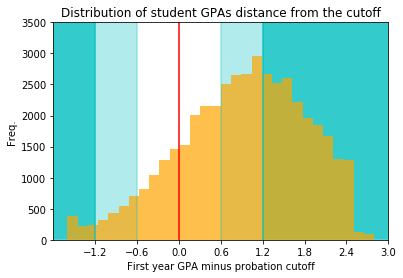

In [4]:
plot_hist_GPA(data)

In [5]:
# Reduce sample to students within 1.2 points from cutoff.
sample12 = data[abs(data['dist_from_cut']) < 1.2]
sample12.reset_index(inplace=True)
print("A sample of students within 1.2 points from the cuttoff consits of", len(sample12), "observations.")

A sample of students within 1.2 points from the cuttoff consits of 25389 observations.


In [6]:
# Reduce sample to students within 0.6 points from cutoff.
sample06 = data[abs(data['dist_from_cut']) < 0.6]
sample06.reset_index(inplace=True)
print("The final sample includes", len(sample06), "observations.")

The final sample includes 12530 observations.


Table 1 shows the descriptive statistics of the main student characteristics and outcomes in the restricted sample with a bandwidth of 0.6 from the cutoff. The majority of students are female (62%) and native english speakers (72%). Students in the reduced sample on average placed in the 33rd percentile in high school. It should also be noted that quite a large number of students (35%) are placed on probation after the fist year. An additional 11% are placed on probation after the first year.

#### Table 1- Summary statistics

In [7]:
create_table1(sample06)

,Mean,Standard Deviation,Description,Type
hsgrade_pct,33.33,23.29,High School Grade Percentile,Characteristics
totcredits_year1,4.43,0.53,Credits attempted first year,Characteristics
age_at_entry,18.72,0.74,Age at entry,Characteristics
male,0.38,0.48,Male,Characteristics
english,0.72,0.45,English is first language,Characteristics
bpl_north_america,0.87,0.34,Born in North America,Characteristics
loc_campus1,0.48,0.50,At Campus 1,Characteristics
loc_campus2,0.21,0.41,At Campus 2,Characteristics
loc_campus3,0.31,0.46,At Campus 3,Characteristics
dist_from_cut,0.11,0.33,Distance from cutoff in first year,Outcomes


##  5.2. Results

### 5.2.1. Tests of the Validity of the RD Approach

The core motivation in the application of RD approaches is the idea, that the variation in treatment near the cutoff is random if subjects are unable to control the selection into treatment (Lee & Lemieux, 2010). This condition, if fulfilled, means the RDD is able to closely emulate a randomized experiment and allows researchers to identify the causal effects of treatment. 

For evaluating the effects of academic probation on subsequent student outcomes, the RDD is thus a valid approach only if students are not able to precisely manipulate whether they score above or below the cutoff. Lindo et al. (2010) offer multiple arguments to adress concerns about nonrandom sorting: 

1. The study focuses on first year students, assuming this group of students is likely to be less familiar with the probation policy on campus. To verify their conjecture, the authors also conducted a survey in an introductory economics course which revealed that around 50 % of students were unsure of the probation cutoff at their campus. They also claim that this analysis showed no relationship between knowledge of probation cutoffs and studens' grades. 


2. The authors also point out that most first year courses span the entire year and most of the evaluation takes place at the end of the term which would make it difficult for students to purposely aim for performances slightly above the cutoff for academic probation.


3. Finally, and most importantly, the implication of local randomization is testable. If nonrandom sorting were to be a problem, there should be a discontinuity in the distribution of grades at the cutoff with a disproportionate number of students scoring just above the cutoff. Additionally, all the covariates should be continuous throughout the cutoff to ensure that the group above the probation cutoff constitutes a realistic counterfactual for the treated group.

In the following section I first conduct a brief visual and descriptive check of validity before presenting my replication of the validity checks conducted in Lindo et al. (2010).

###  i.  Extension: Visual Validity Check

To check for discontinuities in the covariates and the distribution of students around the cutoff Lindo et al. (2010) use local linear regression analysis. Before implementing the rather extensive validity check conducted by Lindo et al. (2010) I show in this section that a rather simple descriptive and graphical analysis of the distribution of covariates already supports the assumption they are continuous throughout the threshold.

#### Extension | Table - Descriptive Statistics of Treated and Untreated Group close to the Cutoff
The table below shows the means of the different covariates at the limits of the cutoff from both sides (here within a bandwidth of 0.1 grade points). We can see that the means of the groups below and above the probation cutoff are very similar, even equal for some of the variables.

In [8]:
cov_descriptives = describe_covariates_at_cutoff(sample06,bandwidth=0.1)
cov_descriptives

Below cutoff        Above cutoff         \
                          Mean   Std.         Mean   Std.   
hsgrade_pct              30.94  22.61        31.76  22.65   
totcredits_year1          4.42   0.55         4.37   0.54   
age_at_entry             18.73   0.76        18.72   0.75   
male                      0.38   0.49         0.38   0.49   
english                   0.70   0.46         0.72   0.45   
bpl_north_america         0.88   0.33         0.87   0.34   
loc_campus1               0.44   0.50         0.45   0.50   
loc_campus2               0.22   0.42         0.21   0.41   
loc_campus3               0.34   0.47         0.34   0.47   

                                    Description  
                                                 
hsgrade_pct        High School Grade Percentile  
totcredits_year1   Credits attempted first year  
age_at_entry                       Age at entry  
male                                       Male  
english               English is first language  
bpl_north_america         Born in North America  
loc_campus1                         At Campus 1  
loc_campus2                         At Campus 2  
loc_campus3                         At Campus 3

#### Extension | Figure - Distribution of covariates throughout the probation cutoff
The figure below shows the means of the nine covariates in bins of size 0.5 (grade points). Similar to the descriptive table shown above, this visualization shows that there seem to be no apparent discontinuities in the distribution of students for any of the observable characteristics (graphs with bins of size 0.1 or 0.025 suggest the same).

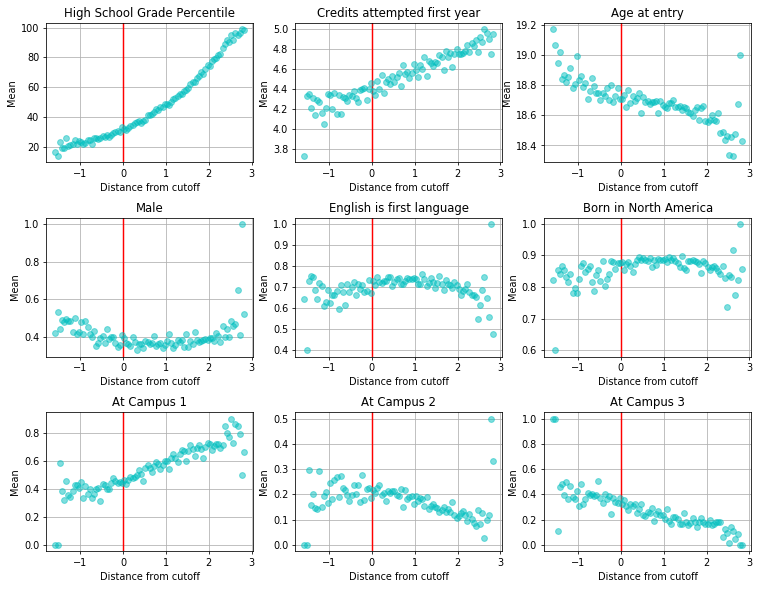

In [9]:
plot_covariates(data=data, descriptive_table=cov_descriptives,bins = 'dist_from_cut_med05')

### ii. Advanced Validity Check
(as conducted by Lindo et al. (2010))

#### Figure 1 | Distribution of Student Grades Relative to their Cutoff

To test the assumption of local randomization, Lindo et al. (2010) run a local linear regression on the distribution of students throughout the cutoff. As mentioned above, these should be continuous as a jump in the distribution of students around the cutoff would indicate that students can in some way manipulate their GPA to place above the cutoff. 

For the analysis the data (containing all observations within 1.2 GPA points from the cutoff) is sorted into bins of size 0.1. The bins contain their lower limit but not their upper limit. To replicate the result from Lindo et al. (2010), I calculate the frequency of each bin and then run a local linear regression with a bandwidth of 0.6 on the size of the bins. Figure 1 shows the bins and the predicted frequency for each bin. The results show that the distribution of grades seems to be continuous around the cutoff, suggesting that we can assume local randomization. 

This method of testing the validity is especially useful because it could capture effects of unobservables, whose influence we cannot otherwise test like we test for discontinuities in observable characteristics in the parts above and below. If all observable characteristics would shows to be continuous throughout the cutoff but we could still observe a jump in the distribution of students above the cutoff, this would suggest that some unobservable characteristic distinguishes students above and below the probation threshold. Fortunately, the results shown below indicate that this is not the case supporting the RDD as a valid identification strategy.

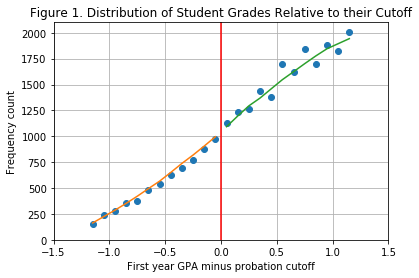

In [10]:
bin_frequency_fig1 = calculate_bin_frequency(sample12, "dist_from_cut_med10")
predictions_fig1 = create_bin_frequency_predictions(bin_frequency_fig1, bin_frequency_fig1.bins.unique().round(4), 0.6)
plot_figure1(bin_frequency_fig1, bin_frequency_fig1.bins.unique().round(4), predictions_fig1)

#### Table 2 - Estimated Discontinuities in observable characteristics 

Table 2 shows the results of local linear regression (using a bandwidth of 0.6) for a range of observable characteristics that are related to student outcomes. Significant discontinuities would indicate that students with certain characteristics might be able to manipulate their grades to score above the probation cutoff. Similar to the descriptive validity checks on covariates in the section, these results additionally support the validity of the RDD. Table 2 shows that the coefficient for scoring below the cutoff is insignificant at the 10% level for all covariates. 

In [11]:
table2_variables = ('hsgrade_pct', 'totcredits_year1', 'age_at_entry', 'male', 'english', 
                    'bpl_north_america','loc_campus1', 'loc_campus2')
regressors = ['const', 'gpalscutoff', 'gpaXgpalscutoff', 'gpaXgpagrcutoff']

In [12]:
table2 = estimate_RDD_multiple_outcomes(sample06, table2_variables, regressors)
table2.style.applymap(color_pvalues, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
outcomes,,,,,,,
hsgrade_pct,0.45,0.72,1.259,30.991,0,0.745,12530
totcredits_year1,0.024,0.749,0.076,4.386,0,0.046,12530
age_at_entry,0.015,0.641,0.032,18.719,0,0.021,12530
male,0,0.989,0.024,0.374,0,0.012,12530
english,-0.037,0.124,0.024,0.729,0,0.015,12530
bpl_north_america,0.017,0.173,0.013,0.864,0,0.008,12530
loc_campus1,0.012,0.724,0.034,0.444,0,0.022,12530
loc_campus2,-0.01,0.719,0.027,0.217,0,0.018,12530


---
<span style="color:orange">**NOTE**:</span> My results for 'Male' and 'Age at entry' are switched compared to the table presented in Lindo et al. (2010). Since the results are identical otherwise, I assume this difference stems from an error in the table formatting of the published paper.

<span style="color:orange">**NOTE**:</span> The p-values in all regression tables are color coded for enhanced clearness of the results:

* P-values at the <span style="color:magenta">10% level</span> are magenta,
* P-values at the <span style="color:red">5 % level</span> are red,
* P-values at the <span style="color:orange">1 % level</span> are orange.

The color coding may not be visible in all viewing options for Jupyter notebooks (e.g. mybinder).

---

### 5.2.2. First year GPAs and Academic Probation

Figure 2 and the Table 3 show the estimated discontinuity in probation status. Figure 2 and the first part of Table 3 show the estimated discontinuity for the probation status after the _first year_. The second part of Table 3 presents the results for the estimated effects of scoring below the cutoff on the probability of _ever_ being placed on academic probation.

Figure 2 and part 1 of Table 3 verifying that the discontinuity at the cutoff is **sharp**, i.e. all students whose GPA falls below the cutoff are placed on probation. For students below the cutoff the probability of being placed on probation is 1, for students above the cutoff it is 0.

It should be noted that the estimated discontinuity at the cutoff is only approximately equal to 1 for all of the different subgroups, as the results in Part 1 of Table 3 show. The authors attribute this fact to administrative errors in the data reportage. 

#### Figure 2 - Porbation Status at the End of First Year

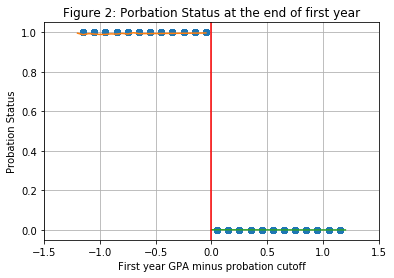

In [13]:
predictions_fig2 = create_predictions(sample12, 'probation_year1', regressors, 0.6)
plot_figure2(sample12, predictions_fig2)

#### Table 3 - Estimated Discontinuity in Probation Status

To estimate the discontinuity in probation status, the authors again use a bandwidth of 0.6 from the cutoff. In addition to the whole sample this condition applies to, they also estimate the discontinuities for certain subgroups in the sample:

* **high school grades below** and **above the median** (here, median refers to the median of the entire dataset (median: _50_) and not the median of the subset of students with a GPA within 0.6 grade points of the probation cutoff (the median for this set would be _28_))
* **male** and **female** students
* **english** native speakers and students with a different native language (**nonenglish**) 

In [14]:
sample_treat06 = sample06[sample06['dist_from_cut'] < 0]
sample_untreat06 = sample06[sample06['dist_from_cut'] >= 0]
sample06 = pd.concat([sample_untreat06, sample_treat06])
groups_dict_keys = ['All', 'HS Grades < median', 'HS Grades > median', 'Male', 'Female',
                    'Native English', 'Nonnative English']
groups_dict_columns = ['const', 'lowHS', 'highHS','male', 'female', 'english', 'noenglish']
groups_dict_06 = create_groups_dict(sample06, groups_dict_keys, groups_dict_columns)

**Table 3 | Part 1 - Estimated Discontinuity in Probation Status for Year 1**


In [15]:
table3_1 = estimate_RDD_multiple_datasets(groups_dict_06, groups_dict_keys, 'probation_year1', regressors)
table3_1.style.applymap(color_pvalues, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,0.994,0,0.002,0.001,0.157,0.001,12530
HS Grades < median,0.995,0,0.002,0.001,0.183,0.001,9473
HS Grades > median,0.99,0,0.006,0.001,0.317,0.001,3057
Male,0.99,0,0.005,0.001,0.319,0.001,4701
Female,0.996,0,0.002,0.001,0.179,0.001,7829
Native English,0.993,0,0.002,0.001,0.16,0.001,9006
Nonnative English,0.997,0,0.003,0,0,0,3524


**Table 3 | Part 2 - Estimated Discontinuity in Probabtion Status Ever**

Part 2 of Table 3 presents the estimated effect of scoring below the cutoff in the first year for _ever_ being placed on probation. The results show that even of those who score slightly above the probation cutoff in year 1, 33 % are placed on probation at some other point in time during their studies. 

For the different subgroups of students this value varies from 29% (for students with high school grades above the median) up to 36.7% (for the group of males). These results already indicate that we can expect heterogeneities in the way different students react to being placed on academic probation.

The fact that it is not unlikely for low performing students just slightly above the cutoff to fall below it later on also underlines these student's fitness as a control group for the purpose of the analysis. Lindo et al. (2010) argue that the controls can be thought of as receiving a much weaker form of treatment than the group that is placed on probation, as scoring just above the cutoff in year 1 does not save students from falling below the cutoff and being placed on probation in subsequent terms. 

In [16]:
table3_1 = estimate_RDD_multiple_datasets(groups_dict_06, groups_dict_keys,'probation_ever',regressors)
table3_1.style.applymap(color_pvalues, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,0.665,0,0.014,0.33,0,0.014,12530
HS Grades < median,0.653,0,0.014,0.343,0,0.014,9473
HS Grades > median,0.705,0,0.023,0.286,0,0.022,3057
Male,0.625,0,0.016,0.366,0,0.015,4701
Female,0.69,0,0.017,0.308,0,0.017,7829
Native English,0.677,0,0.016,0.317,0,0.016,9006
Nonnative English,0.635,0,0.023,0.362,0,0.022,3524


### 5.2.3. The Immediate Response to Academic Probation 

Students who have been placed on academic probation enter their next term at university with the threat of suspension in case they fail to improve their grades. Recalling the theoretical framework presented in prior sections, students face the following set of options after each term:

1. **Option 1**: Return to school, exhibit low effort and achieving a low GPA,
2. **Option 2**: Return to school, exhibit high effort with the intent of achieving a high GPA,
3. **Neither** option: Drop out of university.

Students on probation face a different set of choices than the students that were not placed on probation as the threat of suspension essentially eliminates option 1. Of course students could enter the next term, exhibit low effort and receive low grades but this would result in suspension. Since both option 1 and option 3 result in the student not continuing school (at least for a certain period of time), students who are cannot or meet the performance standard (thus leading to suspension) are much better off dropping out and saving themselves the cost of attending university for another term.

#### Table 4 - Estimated Effect on the Decision to Leave after the First Evaluation

In [17]:
table4 = estimate_RDD_multiple_datasets(groups_dict_06, groups_dict_keys, 'left_school', regressors)
table4.style.applymap(color_pvalues, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,0.018,0.01,0.007,0.041,0,0.004,12530
HS Grades < median,0.013,0.107,0.008,0.045,0,0.005,9473
HS Grades > median,0.032,0.058,0.017,0.026,0,0.007,3057
Male,0.037,0.014,0.015,0.038,0,0.007,4701
Female,0.006,0.53,0.009,0.043,0,0.004,7829
Native English,0.028,0.003,0.01,0.047,0,0.005,9006
Nonnative English,-0.004,0.713,0.011,0.025,0,0.007,3524


The results presented in Table 4 and and Figure 3 show the effects of being placed on probation on the probability to drop out of school after the first evaluation. The first row of Table 4 shows the average effect of academic probation on this outcome. The results indicate that, on average, being placed on probation increases the probability of leaving university by 1.8 percentage points. A student on academic probation is thus 44% more likely to drop out than their control group counterpart.

The results presented in the rest of Table 4 and and Figure 3 show that the average effect of being placed on probation is also characterized by large heterogeneities between the different subgroups of students. For males and native english speakers, the results, which are significant at the 5% level, show an increase of 3.7 and 2.8 percentage points respectively in the probability of leaving university after being placed on probation after the first evaluation. The results show no significant effects for these group's counterparts, the subgroups of females and nonnative english speakers. 

Aside from gender and native language, the results also indicate that high school performance seems to play a role in how students react on being placed on probation. For the group of students who scored above the median in high school academic probation roughly doubles the probability of leaving school compared to the control group while there is no such effect for students who scored below the median in high school. Lindo et al. (2010) contribute this finding to a discouragement effect for those students who are placed on probation, which seems to be larger for students who did well in high school.

#### Figure 3 - Stratified Results for Voluntarily Leaving School at the End of the First year

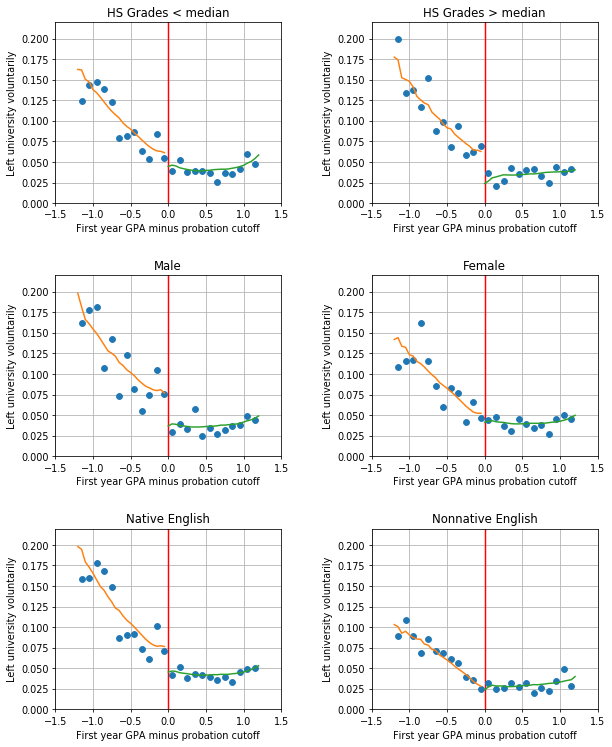

In [18]:
groups_dict_12 = create_groups_dict(sample12, groups_dict_keys, groups_dict_columns)
predictions_groups_dict = create_fig3_predictions(groups_dict_12, regressors, 0.6)
plot_figure3(groups_dict_12, predictions_groups_dict, groups_dict_keys)

### 5.2.4. The Impact on Subsequent Performance

### i. Main Results for Impact GPA & Probability of placing above Cutoff in the next Term

The next outcome Lindo et al. (2010) analyze is the performance of students who stayed at university for the next term. The theoretical framework presented in Section 2 predicts that those students on probation who stay at university will try to improve their GPA. Indeed, if they do not manage to improve, they will be suspended and could have saved themselves the effort by dropping out.

The results presented in Figure 4 and Table 5 show the estimated discontinuity in subsequent GPA. Lindo et al. (2010) find significant results (at the 5% level) for all subgroups, which is an even bigger effect than that of probation on drop out rates, where only some subgroups were affected. 

#### Figure 4 - GPA in the next enrolled term

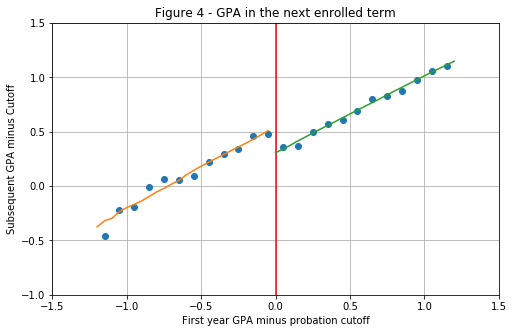

In [19]:
predictions_fig4 = create_predictions(sample12, 'nextGPA', regressors, 0.6)
plot_figure4(sample12, predictions_fig4)

As part A of Table 5 shows, the average treatment effect on the GPA in the next term is positive for all groups of students. The average student on probation has a GPA increase of 0.23 grade points which is 74% of the control group. 

The increase is greatest for students who have high school grades below the median. These students increase their GPA by 0.25 grade points on average, 90% more than their control group. This is an interesting finding because the counterpart, students who scored above the median in high school, are especially likely to drop out. Thus high school grades seem to have large effect on whether students perceive academic probation as a discouragement or as an incentive to improve their performance. 

It should be noted here, that the '_next term_' may not be the next year for all students because some students take summer classes. If students fails to improve their grades during summer classes, they are already suspended after summer and will not enter the second year. Only using grades from the second year would thus omit students who were suspended before even entering the second year. The existence of summer classes may complicate the comparability of students after being put on probation. However, in a footnote Lindo et al. (2010) mention that they find no statistically significant impact of academic probation on the probability that a student enrolls in summer classes and the estimates for subsequent GPA are nearly identical when controlling for whether a students next term was attending a summer class.

---
<span style="color:orange">**NOTE**:</span> Lindo et al. (2010) in this call this the _'improvement_' of students' GPA, however, this phrasing in my opinion could be misleading, as the dependent variable in this analysis is the distance from cutoff in the next term. The results thus capture the increase in subsequent GPA in general and not relative to the GPA in the prior term.

---

#### Table 5 - Estimated Discontinuites in subsequent GPA | Part A - Next Term GPA

In [20]:
table5 = estimate_RDD_multiple_datasets(groups_dict_06, groups_dict_keys, 'nextGPA', regressors)
table5.style.applymap(color_pvalues, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,0.233,0,0.026,0.312,0,0.018,11258
HS Grades < median,0.247,0,0.029,0.275,0,0.02,8457
HS Grades > median,0.179,0.028,0.081,0.443,0,0.044,2801
Male,0.207,0,0.044,0.281,0,0.027,4166
Female,0.246,0,0.036,0.33,0,0.024,7092
Native English,0.229,0,0.036,0.309,0,0.02,8012
Nonnative English,0.24,0,0.055,0.318,0,0.035,3246


#### Table 5 - Estimated Discontinuites in subsequent GPA | Part B - Probability placing above the cutoff in next term

Panel B of Table 5 shows the probability of scoring above the cutoff in the next term. This statistic is very important because it decides whether students on academic probation are suspended after the subsequent term. It is therefore important for students who scored below the cutoff in the fist year to not only improve their GPA, but improve it enough to score above the cutoff in the next term. Again academic probation increases the probability of students scoring above the cutoff in the next term for all subgroups.

In [21]:
table5 = estimate_RDD_multiple_datasets(groups_dict_06, groups_dict_keys,'nextGPA_above_cutoff', regressors)
table5.style.applymap(color_pvalues, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,0.099,0,0.014,0.693,0,0.009,11258
HS Grades < median,0.109,0,0.017,0.68,0,0.011,8457
HS Grades > median,0.061,0.073,0.034,0.737,0,0.02,2801
Male,0.075,0.001,0.022,0.68,0,0.013,4166
Female,0.111,0,0.022,0.7,0,0.014,7092
Native English,0.112,0,0.02,0.691,0,0.011,8012
Nonnative English,0.07,0.004,0.024,0.697,0,0.019,3246


### ii. Formal Bound Analysis on Subsequent GPA (partial extension)

As already mentioned in the section on the identification strategy, analyzing outcomes that occur after the immediate reaction to probation (the decision whether to drop out or not) becomes more challenging if we find that students are significantly more or less likely to drop out if they have been placed on academic probation. As discussed in the preceding section, this is the case because some groups of students indeed are more likely to drop out if they have been placed on probation.

For the analysis of subsequent GPA this means that the results become less reliable because there is a group of students (those who dropped out) whose subsequent performance cannot be observed. This can cause the results to be biased. For example if academic probation causes students with relatively low ability to drop out (which the performance model would predict) then we would find a positive impact on subsequent GPA being solely driven by the fact that the low performers in the treatment group dropped out. If on the other hand high ability students were more likely to drop out, the estimates for impact on subsequent performance would be downward biased.

In short, the control group might not be comparable anymore. To test whether the results on subsequent GPA are robust to these concerns, Lindo et al. (2010) use formal bound analysis for the results on subsequent GPA which I present below.

In addition to this formal bound analysis, I plot confidence intervals for the results on subsequent GPA. Confidence intervals are a useful way to support the graphical analysis of RDDs and ensure the discontinuity at the threshold does not disappear when new population samples are drawn. The graph below shows the estimates from before including a bootstrap 95% percent confidence interval. The confidence interval around the cutoff shows to be quite small, and the fall in subsequent GPA between the treatment and control group persists even at the borders of the confidence interval. 

#### Subsequent performance with 95% confidence interval

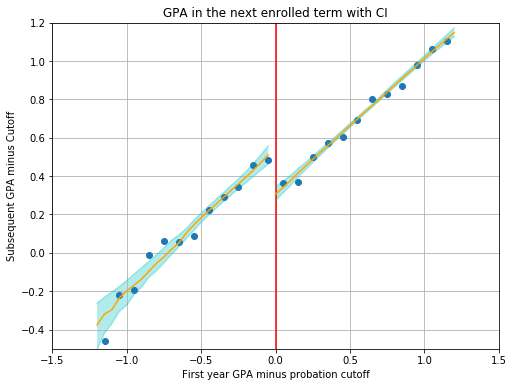

In [22]:
bootstrap_pred = bootstrap_predictions(n=100, data=sample12, outcome='nextGPA', regressors=regressors, bandwidth=0.6)
CI = get_confidence_interval(data=bootstrap_pred, lbound=2.5, ubound=97.5, index_var='dist_from_cut')
predictions_fig4_CI = pd.concat([predictions_fig4, CI[['upper_bound', 'lower_bound']]], axis=1)
plot_figure4_with_CI(data=sample12, pred=predictions_fig4_CI)

---
<span style="color:orange">**NOTE**:</span> The confidence intervals presented here are the product of only 100 resampling iterations of the bootstrap because increasing the amount of times the data is resampled significantly increases the runtime of this notebook. However, I have tested the bootstrap up to 1000 iterations and the results do not diverge very much from the version shown here. 

---

This type of confidence interval however does not correct for potential biases in the treatment or control group discussed above because the bootstrap only resamples the original data and therefore can at best achieve the estimate resulting from the original sample. 

To test the sensitivity to possible nonrandom attrition through specific students dropping out of university, Lindo et al. (2010) perform a formal bound analysis using a trimming procedure proposed by Lee (2009)*. The reasoning to this approach is based on the concerns described above. To find a lower bound of the estimate Lindo et al. (2010) assume that academic probation causes students who would have performed worse in the next term to drop out. The control group is thus made comparable by dropping the lowest performing students (in the next term) from the sample, assuming these students would have dropped out had they been placed on probation. To calculate the upper bound estimate, the same share of students is dropped from the upper part of the grade distribution instead. 

The share of students who need to be dropped is given by the estimated impact of probation on leaving school. For example, in the entire sample students on probation are 1.8 percentage points more likely top drop out, which is 44% of the control mean. Thus, to make the groups comparable again we presumably need to drop 44% more students from the control group than actually dropped out. 

For groups of students where the estimated impact of probation on leaving school is negative, students from the control group need to be dropped instead (i.e. here the lower bound is given by dropping the top students in the treatment group and the upper bound is given by dropping the bottom students). 

While all results I have presented in this replication so far are exactly identical to the results from Lindo et al. (2010), I unfortunately cannot replicate the results from the formal bound analysis precisely. The description in the paper is brief and the provided STATA code from the authors does not include the formal bound analysis. While referring to methods presented in Lee (2009) has been helpful to understand the trimming procedure, I am unable to replicate the exact numbers presented in Lindo et al. (2010).

The table pictured below shows the results of the formal bound analysis presented in Lindo et al. (2010). The authors conclude that the positive effects of academic probation on students' subsequent GPA are too great to be explained by the attrition caused by dropouts. 

---
<span style="color:orange">**NOTE**:</span> In their paper Lindo et al. (2010) quote _'Lee (2008)'_ which could also refer to a different paper by Lee and Card from 2008 listed in the references. However, since this paper in contrast to the 2009 paper by Lee does not mention formal bound analysis and since Lee (2009) is not mentioned anywhere else in the paper, I am certain this is a citation error.

---

#### Formal bound analysis from Lindo et al. (2010) (p.110)

![ERROR: Here should be a picture of the bounds from the paper](files/bounds_nextGPA.PNG)

The table below shows my results using the proposed trimming procedure (table is again transposed compared to the original). The overall results are quite similar to the ones presented in Lindo et al. (2010), all estimates presented in Table 5 still lie between the lower and upper bound. It should be noted that in my replication the lower bound estimate for students with high school grades above the median was not significant at the 10% level while the results for all other groups were.

#### Replication of formal bound analysis

In [23]:
table4['add_leavers'] = round(table4['GPA below cutoff (1)']/table4['Intercept (0)'],2)
add_leavers = table4['add_leavers']

In [24]:
lb_trimmed_dict_06 = trim_data(groups_dict_06, add_leavers, True, False)
lower_bound = estimate_RDD_multiple_datasets(lb_trimmed_dict_06, groups_dict_keys, 'nextGPA', regressors)

In [25]:
ub_trimmed_dict_06 = trim_data(groups_dict_06, add_leavers, False, True)
upper_bound = estimate_RDD_multiple_datasets(ub_trimmed_dict_06, groups_dict_keys, 'nextGPA', regressors)

In [26]:
bounds = pd.concat([lower_bound.iloc[:,[0,2]],upper_bound.iloc[:,[0,2]]], axis=1)
bounds.columns = pd.MultiIndex.from_product([['Lower Bound Estimate','Upper Bound Estimate',],
                                             ['GPA below cutoff (1)', 'Std.err (1)']])
bounds

Lower Bound Estimate             Upper Bound Estimate  \
                   GPA below cutoff (1) Std.err (1) GPA below cutoff (1)   
groups                                                                     
All                               0.175       0.025                0.259   
HS Grades < median                0.211       0.028                0.267   
HS Grades > median                0.036       0.082                0.215   
Male                              0.108       0.043                0.261   
Female                            0.229       0.036                0.248   
Native English                    0.140       0.035                0.261   
Nonnative English                 0.215       0.053                0.256   

                                
                   Std.err (1)  
groups                          
All                      0.026  
HS Grades < median       0.029  
HS Grades > median       0.079  
Male                     0.042  
Female                   0.036  
Native English           0.035  
Nonnative English        0.056

### 5.2.5. The Impacts on Graduation

As a third outcome, Lindo et al. (2010) examine the effects of academic probation on students' graduation rates. As already discussed in the previous section, the outcomes that are realized later in time are more complex to examine because of all the different choices a student has made until she or he reaches that outcome. Graduation rates are the product of a dynamic decision making process that spans throughout the students' time at university. While the study focuses mainly on the effects of being put on probation after year 1, the decision problem described in the theoretical framework can be faced by a students at different points during their academic career as students can be placed on probation each term or for multiple terms in a row. There are different ways in which academic probation could affect graduation rates. On the one hand it could reduce the probability of graduating because probation increases the probability of dropping out and some students who fail to increase their grades are suspended. On the other hand, these students might graduated either way and thus do not have an effect. Additionally, probation could increase graduation rates because those students who remain improve their performance. 

#### Figure 5 - Graduation Rates

Figure 5 and Table 6 show the estimated impacts of academic probation after the first year on whether a student has graduated in four, five or six years. The effects are negative for all three options, suggesting that the negative effects discussed above overweigh potential positive effects on graduation rates.

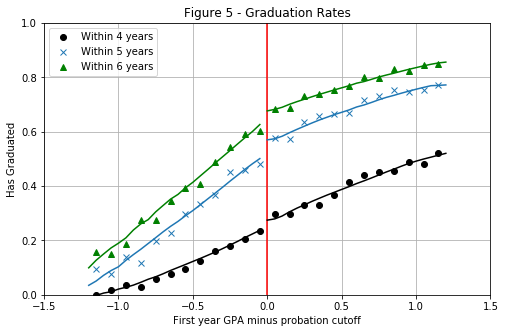

In [27]:
plot_figure5(sample12, 
             create_predictions(sample12,'gradin4', regressors, 0.6), 
             create_predictions(sample12,'gradin5', regressors, 0.6), 
             create_predictions(sample12,'gradin6', regressors, 0.6))

#### Table 6 - Estimated Effects on Graduation

The effects on graduation rates are insignificant for most subgroups, the group of students with high school grades above the median stands out as being especially negatively affected by being placed on probation in the first year. This group of students sees their probability of graduation within six years reduced by 14.5 percent. Lindo et al. (2010) attribute these results to the fact that this group of students is especially likely to drop out after being put on probation and also on average does not do much better than their counterpart if they continue to attend university.

Overall the results on graduation rates are rather limited. This likely stems from the more complex nature in which probation in the first year can affect this outcome later down the line. Unfortunately, most of the data in the provided dataset focuses on the first two years of students' time at university (e.g. we only now the GPA of the first two years). Much more information would be needed to uncover the mechanisms in which probation may affect students probability of graduating within specific timeframes.

---
<span style="color:orange">**NOTE**:</span> Below I only show the sections of Table 6 that are discussed above as the entire table is quite extensive. The other results presented in Table 6 of the paper can be viewed by uncommenting the code at the end of this section.

---

#### Graduated after 6 years

In [28]:
table6 = create_table6(groups_dict_06, groups_dict_keys, regressors)
table6.loc[['All','HS Grades > median' ], 
           'Graduated after 6 years'].style.applymap(color_pvalues, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,-0.024,0.316,0.024,0.674,0,0.018,6005
HS Grades > median,-0.145,0.006,0.053,0.76,0,0.022,1356


**Code for complete Table 6:**

In [29]:
# table6.loc[:, 'Graduated after 4 years'].style.applymap(color_pvalues, subset=['P-Value (1)', 'P-Value (0)'])

In [30]:
# table6.loc[:, 'Graduated after 5 years'].style.applymap(color_pvalues, subset=['P-Value (1)', 'P-Value (0)'])

In [31]:
# table6.loc[:, 'Graduated after 6 years'].style.applymap(color_pvalues, subset=['P-Value (1)', 'P-Value (0)'])

---
# 6. Extension: Robustness Checks 
---

As discussed in my replication of Lindo et al. (2010) above, the authors use a variety of validity and robustness checks to analyze the reliability of their results. Aside from some smaller independent contributions that I already discuss in the replication part for better context,  I in this section further analyze subsequent performance and check the bandwidth sensitivity of the results in drop out rates and subsequent GPA.

## 6.1.  A closer look at student's subsequent performance. 

### 6.1.1. Subsequent Performance and Total Credits in Year 2

The results from Lindo et al. (2010) presented above show that students are more likely to drop out after being placed on academic probation but those who remain in school tend to improve their GPA above the cutoff in the next term. These results are generally in line with the theoretical framework presented in the paper which predicts that students either drop out or improve their GPA if the cost of not improving in the next term increases. The performance standard model explains these results through students self selecting between increasing effort and dropping out based on their abilities (which are defined as the probability of meeting the performance standard). Students who are less likely to improve their GPA should thus be more likely to drop out. Unfortunately, it is not possible to test this prediction, as Lindo et al. (2010) emphasize in the paper, because the probability of meeting the performance standard is not observed for students who leave school. 

However, examining the students who remain in school may give some further insights. While Lindo et al. (2010) observe that  students have been placed on probation on average improve their performance, it is not clear under which circumstances this is happening. A look at the amount of credits students are taking in their second year may give some insights. The results presented below show that being placed on probation after the first year has a negative effect on the amount of credits students take in year 2 for all of the examined subgroups except the group of nonnative english speakers. This is a stark contrast to the first year where both the treatment and control group take almost the same amount of credits (as shown in the section on the validity of the RD Approach).

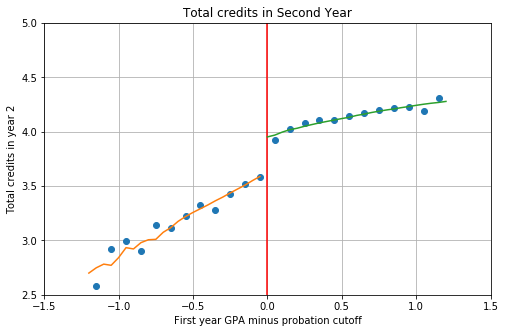

In [32]:
predictions_credits_year2 = create_predictions(sample12, 'total_credits_year2', regressors, 0.6)
plot_figure_credits_year2(sample12, predictions_credits_year2)

The results indicate that being placed on probation decreases the total credits taken by the average student in year two by 0.33, around 8% of the control mean. As the table below shows, the results are most prominent for males, native english speakers and students with high school grades above the median. Interestingly, these are the same groups of students that are most likely to drop out, suggesting that the discouragement effect persists throughout these groups an even those who re-enroll for the next term precede with caution by taking less credits.

In [33]:
table_total_credits_year2 = estimate_RDD_multiple_datasets(groups_dict_06, groups_dict_keys, 
                                                           'total_credits_year2',regressors)
table_total_credits_year2.style.applymap(color_pvalues, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,-0.326,0,0.06,3.953,0,0.036,11126
HS Grades < median,-0.29,0,0.069,3.906,0,0.04,8349
HS Grades > median,-0.453,0,0.112,4.115,0,0.041,2777
Male,-0.38,0,0.084,3.839,0,0.049,4109
Female,-0.301,0,0.067,4.021,0,0.043,7017
Native English,-0.283,0,0.054,4.029,0,0.032,7928
Nonnative English,-0.374,0.004,0.13,3.756,0,0.067,3198


When interpreting these results it should be kept in mind that some students' next evaluation takes place during summer classes. Students who have taken summer classes enter their second year already having either passed the next evaluation or not. Those who fell below the cutoff will have been suspended and thus are missing from the data for the second year and those who have passed the threshold in the summer classes are likely not on probation anymore. Estimating the effects of probation on credits taken in the second year separately for both groups shows that those who did not take classes in the summer are more affected than those who did. For the students who took summer classes, the results are only significant for males, students with high school grades above the median and native english speakers.

#### No summer classes

In [34]:
sample06_nosummer = sample06[sample06.summerreg_year1 == 0]
groups_dict_06_nosummer = create_groups_dict(data=sample06_nosummer, keys=groups_dict_keys,columns=groups_dict_columns)
table_totcred_y2_nosummer = estimate_RDD_multiple_datasets(groups_dict_06_nosummer,groups_dict_keys,
                                                           'total_credits_year2',regressors)
table_totcred_y2_nosummer.style.applymap(color_pvalues, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,-0.187,0,0.048,4.112,0,0.03,6820
HS Grades < median,-0.192,0.002,0.062,4.088,0,0.034,5137
HS Grades > median,-0.173,0.058,0.091,4.204,0,0.045,1683
Male,-0.155,0.042,0.076,3.988,0,0.049,2653
Female,-0.22,0,0.058,4.197,0,0.042,4167
Native English,-0.183,0.001,0.053,4.143,0,0.032,5333
Nonnative English,-0.173,0.044,0.086,3.99,0,0.062,1487


#### Summer classes

In [35]:
sample06_summer = sample06[sample06.summerreg_year1 == 1]
groups_dict_06_summer = create_groups_dict(sample06_summer,groups_dict_keys,groups_dict_columns)
table_totcred_y2_summer = estimate_RDD_multiple_datasets(groups_dict_06_summer,groups_dict_keys,
                                                         'total_credits_year2',regressors)
table_totcred_y2_summer.style.applymap(color_pvalues, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,-0.552,0,0.095,3.725,0,0.058,4306
HS Grades < median,-0.452,0,0.117,3.646,0,0.061,3212
HS Grades > median,-0.898,0,0.201,3.989,0,0.096,1094
Male,-0.75,0,0.151,3.577,0,0.072,1456
Female,-0.448,0,0.105,3.798,0,0.07,2850
Native English,-0.518,0,0.13,3.818,0,0.058,2595
Nonnative English,-0.56,0.003,0.188,3.577,0,0.093,1711


These findings are useful for interpreting the subsequent performance of students because more credits likely signify a larger workload for the student. Instead of increasing their effort, students may just decrease their workload by completing less credits in the next term. Unfortunately, we cannot test this in detail because the data doesn't shows how many credits students completed in which term. 

Reducing the sample for the analysis of the subsequent GPA to students who did not attend summer classes and completed 4 credits in the second year (the most frequent amount of credits take by this group of students) shows that the effect of scoring below the cutoff in year 1 becomes insignificant for the students who have above median high school grades and nonnative english speakers. The improvement decreases a bit for some groups like females or students with high school grades below the median but increases for others like males and native english speakers. Overall the results are still highly significant though considering the small window of observations to which the data is reduced in this case. This suggest that while students on probation do seem take fewer credits in the next year, the improvements to subsequent performance is too great to just be attributed to students decreasing their workload. 

In [36]:
sample06_many_credits = sample06_nosummer[(sample06_nosummer.total_credits_year2 == 4)]
groups_dict_06_manycredits = create_groups_dict(sample06_many_credits,groups_dict_keys,groups_dict_columns)
table_manycredits = estimate_RDD_multiple_datasets(groups_dict_06_manycredits,groups_dict_keys,
                                                         'nextGPA',regressors)
table_manycredits.style.applymap(color_pvalues, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,0.188,0,0.047,0.314,0,0.027,2003
HS Grades < median,0.22,0,0.052,0.265,0,0.035,1524
HS Grades > median,0.072,0.586,0.132,0.476,0,0.073,479
Male,0.273,0.001,0.082,0.289,0,0.046,748
Female,0.144,0.031,0.067,0.331,0,0.04,1255
Native English,0.252,0,0.055,0.272,0,0.032,1578
Nonnative English,-0.051,0.609,0.1,0.473,0,0.062,425


### 6.1.2. Subsequent Cumulative Grade Point Average (CGPA) 

An additional factor that might be important for the analysis of subsequent performance is the Cumulative Grade Point Average (CGPA). Lindo et al. (2010) focus their analysis of subsequent performance solely on the grades achieved in the next term. However, in the section on the institutional background in the paper the authors write:

>*At all campuses, students on probation can avoid suspension and return to good academic standing by bringing their cumulative GPA up to the cutoff.* (Lindo et al., 2010, p.98).

In order to avoid suspension in the long term, students on probation thus are required to not only score above the cutoff in the next term, but to score high enough to bring their CGPA above the probation threshold. Students who score above the threshold in the next term but still have a CGPA below the cutoff remain on probation. Students who fail to bring their GPA above the cutoff (and thus also their CGPA since their first year GPA and first year CGPA are the same) are suspended. 

As the figure and table below show, the positive effects of probation on subsequent performance carry over to students' CGPA as well. Being placed on probation on average increases students' CGPA by 0.07 grade points or 63% of the control mean although the difference is rather difficult to spot visually.

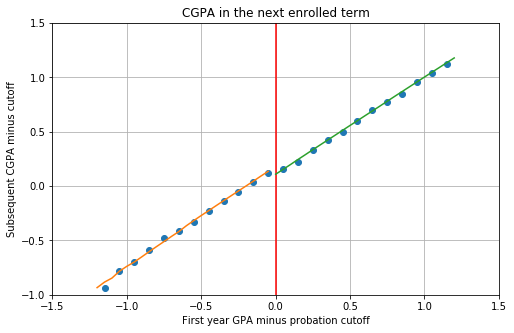

In [37]:
predictions_nextCGPA = create_predictions(sample12, 'nextCGPA', regressors, 0.6)
plot_nextCGPA(sample12, predictions_nextCGPA)

#### Effect of Academic Probation on subsequent CGPA

In [38]:
table_nextCGPA = estimate_RDD_multiple_datasets(groups_dict_06, groups_dict_keys, 'nextCGPA', regressors)
table_nextCGPA.style.applymap(color_pvalues, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,0.07,0,0.01,0.111,0,0.007,11258
HS Grades < median,0.08,0,0.01,0.094,0,0.007,8457
HS Grades > median,0.031,0.267,0.028,0.167,0,0.016,2801
Male,0.059,0,0.016,0.102,0,0.011,4166
Female,0.075,0,0.013,0.116,0,0.008,7092
Native English,0.077,0,0.012,0.115,0,0.007,8012
Nonnative English,0.057,0.001,0.017,0.1,0,0.012,3246


However, in contrast to probability of improving the next term GPA above the cutoff, academic probation has no significant effect on the probability of improving the CGPA above the cutoff in the next term except for the group of nonnative english speakers where the probability is actually negative. Indeed, out of all students on probation (within 0.6 grade points of the cutoff) only around 37% improve their next term CGPA above the cutoff. Around 23% improve their GPA above the cutoff but not their CGPA and remain on probation. The other students dropped out or are suspended after the next term. This suggests that the effects of probation span much longer than just the subsequent term for many students, not only indirectly because they have had the experience of being placed on probation but also directly because many of them remain on probation for multiple subsequent terms. These factors underline the points made in previous sections about the complexity of the way academic probation can affect a students academic career. After being placed on probation a student can take a multitude of different paths, many more than the theoretical framework introduced in Section 2 leads on. A more dynamic structural approach to estimating the effects of academic probation could likely offer more insights into how students react to this university policy.

#### Effect of Academic Probation on the Probability of achieving a CGPA above the cutoff in the next term

In [39]:
table_nextCGPA_above_cutoff = estimate_RDD_multiple_datasets(groups_dict_06, groups_dict_keys,'nextCGPA_above_cutoff', 
                                                             regressors)
table_nextCGPA_above_cutoff.style.applymap(color_pvalues, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,-0.014,0.505,0.021,0.758,0,0.013,11258
HS Grades < median,-0.009,0.685,0.023,0.745,0,0.014,8457
HS Grades > median,-0.028,0.513,0.042,0.798,0,0.021,2801
Male,-0.025,0.219,0.02,0.741,0,0.012,4166
Female,-0.009,0.755,0.027,0.768,0,0.017,7092
Native English,0.013,0.542,0.021,0.755,0,0.016,8012
Nonnative English,-0.071,0.026,0.032,0.766,0,0.018,3246


## 6.2. Bandwidth sensitivity 

As a final robustness check, I evaluate the model at different bandwidths to ensure that results are not limited to one specific sample of students within a particular bandwidth. Lindo et al. (2010) use a distance from the threshold of 0.6 for the main regression analysis and 1.2 for graphical analysis (although the estimated curve at each point relies on a local linear regression with a bandwidth of 0.6 as well). The chosen bandwidth around the cutoff thus captures around 25% of the total range of grades (the GPA values observed in the first year span from 0 to 4.3). 

Lindo et al. (2010) do not discuss the reasoning behind their choice of bandwidth in detail and do not apply optimal bandwidth selection methods like some other applications of regression discontinuity (Imbens & Lemieux, 2008; Lee & Lemieux, 2010). However, from a heuristic standpoint this bandwidth choice seems reasonable. Since the cutoff lies at a GPA of 1.5 (1.6 at Campus 3), this bandwidth includes students whose GPA falls roughly between 0.9 and 2.1 grade points, so a range of around one average grade point including the edges. A much larger bandwidth would not makes sense because it would include students that are failing every class and students who are achieving passable grades and are thus not very comparable to students who pass or fall below the threshold by a small margin.

I evaluate bandwidths of length 0.2 (0.1 distance from cutoff on each side) up to 2.4 (1.2 distance from cutoff on both sides). As Lindo et al. (2010), I choose a maximum bandwidth of 1.2 the reasons explained in the paragraph above.

#### Bandwidth sensitivity of the effect of probation on the probability of leaving school

The table below shows the estimated effect of probation on the probability to leave school after the first year using local linear regression (same specification as before) for all bandwidths between 0.1 and 1.2. The bandwidths are on the vertical axis, and the different subgroups are on the horizontal axis of the table. An *x* in the table indicates that the estimate was insignificant at the 10% level and is thus not shown for readability. 

The table shows that the results for the effects on leaving school are relatively sensitive to bandwidth selection. Estimates of students within only 0.2 grade points of the probation threshold are not significant for any of the groups considered. Results for students with high school grades below the median are only significant for bandwidths between 0.3 and 0.5 while estimates for students with high school grades above the median are only significant between values of 0.5 and 0.7. The results for the other subgroups on the other hand seem to be quite robust to bandwidth selection.  

The findings reported in this table suggest that some results presented in the previous sections should be interpreted carefully. Especially the estimates of students based on high school grades might be driven by some underlying factors that are not observed in this study. These could explain the sensitivity of the results to bandwidth selection.

In [40]:
bandwidths = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2]
summary_left_school = bandwidth_sensitivity_summary(data, 'left_school',groups_dict_keys, groups_dict_columns, regressors)
summary_left_school.loc[(bandwidths,'probation'),:]
#summary_left_school  #<- uncommenting this code will reveal the table including pvalues

,,All,HS Grades < median,HS Grades > median,Male,Female,Native English,Nonnative English
0.1,probation,x,x,x,x,x,x,x
0.2,probation,x,x,x,x,x,x,x
0.3,probation,0.021,0.019,x,0.046,x,0.031,x
0.4,probation,0.024,0.022,x,0.063,x,0.037,x
0.5,probation,0.021,0.016,0.038,0.05,x,0.032,x
0.6,probation,0.018,x,0.032,0.037,x,0.028,x
0.7,probation,0.017,x,0.032,0.038,x,0.028,x
0.8,probation,0.014,x,x,0.036,x,0.022,x
0.9,probation,x,x,x,0.037,x,x,x
1.0,probation,x,x,x,0.03,x,x,x


#### Bandwidth sensitivity of the effect of probation on subsequent GPA

The results for the effects of academic probation on subsequent performance on the other hand seem to be quite robust to bandwidth selection. The estimated effects are the highest for most subgroups around the threshold of 0.6 chosen by Lindo et al. (2010) but the effects do not change sign for any subgroup and still remain quite similar.

Again, the group of students with high school grades above the median does not shows significant results for bandwidths between 0.1 and 0.4 and thus seems to be the most sensitive to bandwidth selection. 

In [41]:
summary_nextGPA = bandwidth_sensitivity_summary(data, 'nextGPA', groups_dict_keys, groups_dict_columns, regressors)
summary_nextGPA.loc[(bandwidths,'probation'),:]
# summary_nextGPA    #<- uncommenting this code will reveal the table including pvalues

,,All,HS Grades < median,HS Grades > median,Male,Female,Native English,Nonnative English
0.1,probation,0.191,0.19,x,0.163,0.208,0.134,0.311
0.2,probation,0.172,0.222,x,0.131,0.201,0.154,0.207
0.3,probation,0.233,0.258,x,0.203,0.247,0.221,0.258
0.4,probation,0.241,0.257,x,0.21,0.25,0.237,0.247
0.5,probation,0.227,0.247,0.141,0.183,0.246,0.221,0.237
0.6,probation,0.233,0.247,0.179,0.207,0.246,0.229,0.24
0.7,probation,0.246,0.255,0.216,0.197,0.273,0.238,0.264
0.8,probation,0.232,0.237,0.198,0.181,0.26,0.229,0.237
0.9,probation,0.215,0.221,0.178,0.164,0.242,0.213,0.219
1.0,probation,0.218,0.22,0.189,0.157,0.251,0.211,0.234


---
# 7. Conclusion
---

Overall, the results in this Notebook support the findings reported by Lindo et al. (2010) in their paper. The transparent research methods and STATA code provided by the authors allowed me to reproduce the results precisely for almost all tables and figures except for the formal bound analysis presented in Section 5.2.4. for which I could only produce similar results. In addition to the replication of the main results from Lindo et al. (2010), I discuss the identification strategy used in the paper and evaluate the robustness of the results, especially in the context of the performance standard model used in the paper. The results presented in Lindo et al. (2010) and my additional evaluation offer overall support for the performance standard model by Bénabou and Tirole (2000) which predicts that students who are put on probation will be more likely to drop out of university or improve their performance if remain in school. However, one core feature of the model, the idea that students make their choices based on their ability to meet the performance standard, could not be tested due to the fact that the subsequent performance of students who left school cannot be observed.

Lindo et al. (2010) find large heterogeneities in the way students react to probation based on a set of covariates, however the underlying sources of these heterogeneities is not evaluated. Further analysis of performance standards like academic probation using a larger set of information on student characteristics like personality traits, patience or socioeconomic background may thus be helpful to reveal the reasons why different students react to this negative incentive in certain ways. 

Additionally, the study focused only on the effects of academic probation in the first year and relatively short term outcomes while long term outcomes were not assessed in detail. As already discussed in the section on the effects of academic probation on graduation rates, analyzing long term outcomes is much more difficult because of the multitude of different choices a student can make before reaching a specific outcome. Being placed on probation in the first year already expands the types of paths students may follow greatly. However, students can be placed on probation, suspended or leave school each term. To analyze the long term effects of academic probation in detail there are too many questions that the data used in this study cannot answer. 

Overall the findings from Lindo et al. (2010) offer quite robust results on the effects of academic probation on low performing students. They contribute important insights into how students or individuals in general may react to negative incentives with the threat of severe real world penalties if they fail to adjust their behavior.

---
# 8. References
---

* **Bénabou, R., & Tirole, J. (2000)**. *Self-confidence and social interactions* (No. w7585). National bureau of economic research.


* **Imbens, G. W., & Lemieux, T. (2008)**. Regression discontinuity designs: A guide to practice. *Journal of Econometrics*, 142(2), 615-635.


* **Lee, D. S. (2009)**. Training, wages, and sample selection: Estimating sharp bounds on treatment effects. *The Review of Economic Studies*, 76(3), 1071-1102.


* **Lee, D. S., & Lemieux, T. (2010)**. Regression discontinuity designs in economics. *Journal of Economic Literature*, 48(2), 281-355.


* **Lindo, J. M., Sanders, N. J., & Oreopoulos, P. (2010)**. Ability, gender, and performance standards: Evidence from academic probation. *American Economic Journal: Applied Economics*, 2(2), 95-117.


* **Thistlethwaite, D. L., & Campbell, D. T. (1960)**. Regression-discontinuity analysis: An alternative to the ex post facto experiment. *Journal of Educational Psychology*, 51(6), 309.



-------
                                              Notebook by Annica Gehlen | Find me on GitHub under https://github.com/amageh

---